# Render thank you message

In [3]:
import requests
import pandas as pd
response = requests.get("https://gciro.pythonanywhere.com/metadata")

df = pd.DataFrame(response.json())

a = df.annotator_name.unique().tolist()
names = []
for i in a:

    if "test" in i.lower():
        continue

    splitted = i.split(" ")
    first_name = splitted[0].strip().capitalize()
    last_name = ""
    if len(splitted) > 1:
        last_name = splitted[1].strip().capitalize()[0]+"."
    name = first_name + " " + last_name
    name = name.strip()
    names.append(name)
print(", ".join(sorted(names)))

Claudia, Claudia, Diana, Francesca, Giovanni P., Lorenzo, Matilde, Sara, Simone P., Tommaso D.


# Inspect Trained Model (predictions + gradcam)

Init train dataset with 3875 PNEUMONIA images and 1341 NORMAL images.
Init test dataset with 390 PNEUMONIA images and 234 NORMAL images.


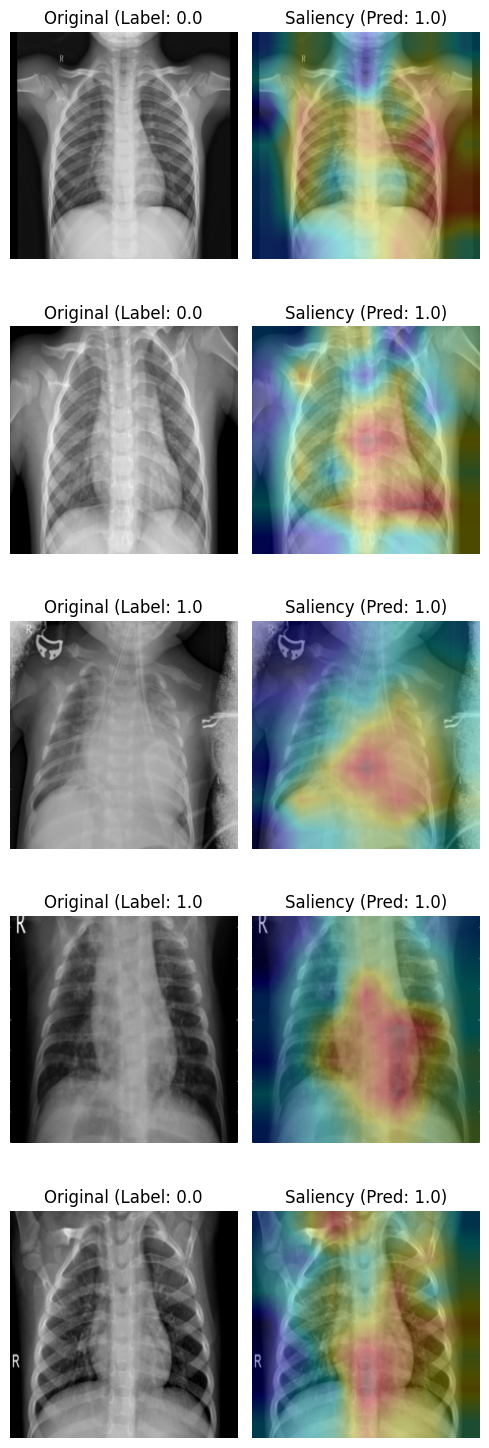

In [9]:
import datamodule
import models
import saliency
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import BaseConfig
import torch

reload(datamodule)
reload(models)
reload(saliency)

PATH_TO_CKPT = "/home/brimax/repos/medimg-saliency-benchmark/medimg-saliency-benchmark/checkpoints/rn_True_False_0.54.ckpt"
ALPHA = 0.3
N = 5  # Number of images to sample
device = "cuda" if torch.cuda.is_available() else "cpu"

def overlay_gradcam_on_image(img_tensor, cam, alpha=0.5):
    # img_tensor: shape [1, 3, H, W] (unnormalized, float [0,1])
    img_np = img_tensor.squeeze(0).detach().cpu().numpy()  # [3, H, W]
    img_np = np.transpose(img_np, (1, 2, 0))      # [H, W, 3]
    img_np = (img_np * 255).astype(np.uint8)

    # Resize cam to match image size
    cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Blend heatmap with original image
    overlay = cv2.addWeighted(img_np, 1 - alpha, heatmap, alpha, 0)
    return overlay

config = BaseConfig("./config.json")
dm = datamodule.Datamodule(config)
dm.setup()
dl = dm.test_dataloader()

# Sample N random indices
indices = np.random.choice(len(dm.test_ds), N, replace=False)
# indices = np.arange(390, 309+N)
# Fetch the corresponding batch of images
images = []
labels = []
for idx in indices:
    X, y = dm.test_ds[idx]
    images.append(X)
    labels.append(y)

# Convert lists to tensors
X = torch.stack(images).to(device)
y = torch.tensor(labels).to(device)

model = models.BaseCNN.load_from_checkpoint(PATH_TO_CKPT).to(device)
model.eval()
pred = model.predict(X)

gcam = saliency.CAM(model.model)
cams = []

for i in range(N):
    single_cam = gcam(X[[i]])  # Add batch dimension with X[[i]]
    cams.append(single_cam)
# Plotting
fig, axes = plt.subplots(N, 2, figsize=(5, 3*N))  # Adjust figure size as needed

for i in range(N):
    # Original Image
    img = X[i].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Original (Label: {y[i].item()}")

    # GradCAM Overlay
    overlay = overlay_gradcam_on_image(X[i:i+1], cams[i], alpha=ALPHA)
    axes[i, 1].imshow(overlay)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Saliency (Pred: {pred[i].item()})")

plt.tight_layout()
plt.show()

# Parse the content of the .json in /evaluation/ and write to a .csv

In [55]:
# Parse the results to write in a nice latex table
import json
import os

# Parse the JSON file
def parse_json_and_format_for_latex(json_data):
    # Load the JSON data
    data = json_data
    
    # Extract the results
    results = data["results"][0]
    
    # Format the metrics with confidence intervals
    # We'll round to 3 decimal places and format as "mean ± half_width"
    metrics = {}
    
    # Calculate and format each metric
    metrics_name = set(k.replace("test/", "").split("_")[0]for k in results.keys())

    for name in metrics_name:
        metrics[name] = {
            "mean": results[f'test/{name}_mean'],
            "pm": (results[f'test/{name}_ci_upper'] - results[f'test/{name}_ci_lower'])/2
        }
    return metrics

payload = "model,linear,pretrained"


for i, evals in enumerate(sorted(os.listdir("evaluation"))):
    
    # Opne json
    with open(f"evaluation/{evals}", "r") as f:
        res = json.load(f)

    # Format csv row
    model, linear, pretrained = evals.split("_")[:3]
    metrics = parse_json_and_format_for_latex(res)

    # Add header 
    if i == 0:
        for name in metrics.keys():
            payload += f",{name},pm"
        payload += "\n"

    # Add values
    payload += f"{model},{linear},{pretrained}"
    for name in metrics.keys():
        mean = metrics[name]["mean"] * 100
        pm = metrics[name]["pm"] * 100
        payload += f",{mean},{pm}"
    payload+="\n"

# Dump to csv
with open("plots/results.csv", "w") as f:
    f.write(payload)

# Read .csv with results and create latex table

In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('plots/results.csv')

# Process the data to restructure it
# Map "linear" column to "Adapted Classifier" for the table
df['adapted_classifier'] = df['linear'].map({True: 'Yes', False: 'No'})
df['pretrained_text'] = df['pretrained'].map({True: 'Yes', False: 'No'})

# Format metrics with their plus/minus values
metrics = ['accuracy', 'f1', 'auroc', 'specificity']  # Changed to use accuracy and f1 instead of precision and recall
for i, row in df.iterrows():
    for metric in metrics:
        # Assuming the pm column follows each metric column
        metric_idx = df.columns.get_loc(metric)
        pm_idx = metric_idx + 1
        
        # Format the value with its plus/minus
        if pd.notna(row[metric]) and pd.notna(row[df.columns[pm_idx]]):
            df.at[i, f"{metric}_formatted"] = f"{row[metric]:.2f} $\\pm$ {row[df.columns[pm_idx]]:.2f}"
        else:
            df.at[i, f"{metric}_formatted"] = "- $\\pm$ -"

# Generate LaTeX table
latex_table = """\\begin{table*}[t]
    \\centering
    \\setlength{\\tabcolsep}{3pt}
    \\caption{Model Performance Metrics}
    \\begin{tabularx}{\\textwidth}{lYYYcccc}
        \\toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC & Specifity\\\\
        \\midrule
"""

# Group by model to handle the multirow structure
models = df['model'].unique()
mapped_names = {
    "vgg": "VGG-16",
    "in": "InceptionNet-V1",
    "an": "AlexNet",
    "rn": "ResNet-50",
}
for i, model in enumerate(models):
    model_df = df[df['model'] == model]
    
    # Group by pretrained status
    pretrained_values = model_df['pretrained'].unique()
    
    # Count rows for multirow
    model_rows = len(model_df)
    model_name = mapped_names[model]
    for j, pretrained in enumerate(pretrained_values):
        pretrained_df = model_df[model_df['pretrained'] == pretrained]
        pretrained_rows = len(pretrained_df)
        
        # Add pretrained status with multirow
        for k, (idx, row) in enumerate(pretrained_df.iterrows()):
            if k == 0 and j == 0:
                # First row of the model
                latex_table += f"        \\multirow{{{model_rows}}}{{*}}{{{model_name}}} &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            elif k == 0:
                # First row of a new pretrained group
                latex_table += f"         &  \\multirow{{{pretrained_rows}}}{{*}}{{{row['pretrained_text']}}}"
            else:
                # Continuation rows
                latex_table += "         &                          "

            latex_table += f" &   {row['adapted_classifier'] if model not in {'in', 'rn'} else '-'}  &   {row['accuracy_formatted']}     &   {row['f1_formatted']}    &   {row['auroc_formatted']} &   {row['specificity_formatted']}\\\\\n"
        
        # Add cmidrule between pretrained groups within the same model (except after the last pretrained group)
        if j < len(pretrained_values) - 1:
            latex_table += "        \\cmidrule(lr){2-6}\n"
    
    # Add midrule between models (except after the last model)
    if i < len(models) - 1:
        latex_table += "        \\midrule\n"

# Close the table
latex_table += """        \\bottomrule
    \\end{tabularx}
    \\label{tab:Performance}
\\end{table*}
"""

print(latex_table)
# Optionally save to a file
with open('plots/results.tex', 'w') as f:
    f.write(latex_table)

\begin{table*}[t]
    \centering
    \setlength{\tabcolsep}{3pt}
    \caption{Model Performance Metrics}
    \begin{tabularx}{\textwidth}{lYYYccc}
        \toprule
        Model & Pretrained & Adapted Classifier & Accuracy & F1 & ROC AUC & Specifity\\
        \midrule
        \multirow{4}{*}{AlexNet} &  \multirow{2}{*}{No} &   No  &   87.42 $\pm$ 2.56     &   90.29 $\pm$ 2.11    &   94.50 $\pm$ 1.72 &   76.84 $\pm$ 5.34\\
         &                           &   Yes  &   87.48 $\pm$ 2.48     &   90.22 $\pm$ 2.05    &   93.40 $\pm$ 1.88 &   78.98 $\pm$ 5.11\\
        \cmidrule(lr){2-6}
         &  \multirow{2}{*}{Yes} &   No  &   91.98 $\pm$ 2.16     &   93.75 $\pm$ 1.72    &   97.01 $\pm$ 1.08 &   84.60 $\pm$ 4.55\\
         &                           &   Yes  &   90.34 $\pm$ 2.24     &   92.72 $\pm$ 1.79    &   96.72 $\pm$ 1.13 &   76.40 $\pm$ 5.06\\
        \midrule
        \multirow{2}{*}{InceptionNet-V1} &  \multirow{1}{*}{No} &   -  &   87.92 $\pm$ 2.49     &   91.11 $\pm$ 1.94  

# Get nice plots from the metrics in /evaluation/

In [79]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Specify the CSV file path
CSV_FILE = "plots/results.csv"  

# Read and process the CSV file with the new format
def read_csv_and_process(csv_file_path):
    """
    Read the CSV file with structure:
    model,linear,pretrained,accuracy,pm,precision,pm,specificity,pm,recall,pm,f1,pm,auroc,pm
    """
    # Read the raw CSV
    df = pd.read_csv(csv_file_path)
    
    # Create a clean dataframe with proper structure
    processed_data = []
    
    # Calculate the number of metrics (excluding the first 3 columns and accounting for the pm columns)
    num_columns = len(df.columns)
    num_metrics = (num_columns - 3) // 2  # Each metric has a value and a pm column
    
    # Process each row
    for _, row in df.iterrows():
        model = row[0]  # model
        linear = row[1]  # linear
        pretrained = row[2]  # pretrained
        model_name = f"{model}_{linear}_{pretrained}"
        if not linear or not pretrained:
            continue
        
        # Extract metric values and their confidence intervals
        metrics_data = {}
        metrics_index = 3  # Start from the 4th column (0-indexed)
        
        # Expected metrics in order: accuracy, precision, specificity, recall, f1, auroc
        metric_names = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
        
        for i in range(num_metrics):
            if metrics_index < len(row):
                metric_name = metric_names[i] if i < len(metric_names) else f"metric_{i}"
                metrics_data[f"{metric_name}_mean"] = row[metrics_index]
                metrics_data[f"{metric_name}_ci_half"] = row[metrics_index + 1]  # pm value
                metrics_index += 2  # Move to the next metric
        
        # Create a row for the model
        processed_row = {
            'model': model,
            'linear': linear,
            'pretrained': pretrained,
            'model_name': model_name,
            **metrics_data  # Add all metrics data
        }
        
        processed_data.append(processed_row)
    
    return pd.DataFrame(processed_data)

# Create bar plots with confidence intervals for each metric
def plot_metrics(df):
    # List of metrics to plot
    metrics = ["accuracy", "precision", "specificity", "recall", "f1", "auroc"]
    
    # Set up the figure size and style
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['figure.figsize'] = (15, 10)
    
    # Create a directory for plots if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    
    for metric in metrics:
        # Skip metrics that don't exist in the dataframe
        if f"{metric}_mean" not in df.columns:
            print(f"Skipping {metric} as it's not in the data")
            continue
            
        plt.figure()
        
        # Prepare data for plotting
        model_names = df['model_name']
        means = df[f'{metric}_mean']
        errors = df[f'{metric}_ci_half']
        
        # Create bar plot with error bars
        plt.bar(model_names, means, yerr=errors, capsize=10, color='skyblue', edgecolor='black')
        
        # Customize the plot
        plt.title(f'{metric.upper()} with 95% Confidence Intervals', fontsize=16)
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(f'{metric.capitalize()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        # Add grid for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Save the figure
        plt.savefig(f'plots/{metric}_barplot.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    print("Generated plots for available metrics")

# Create a single plot with all metrics using seaborn
def plot_all_metrics_together(df):
    # Get all metric columns
    metric_columns = [col for col in df.columns if col.endswith('_mean')]
    ci_columns = [col for col in df.columns if col.endswith('_ci_half')]
    
    # Create a long-form dataframe for seaborn
    melted_df = pd.melt(df, id_vars=['model_name'], 
                        value_vars=metric_columns,
                        var_name='metric', value_name='value')
    
    # Add CI information
    melted_df['metric_base'] = melted_df['metric'].str.replace('_mean', '')
    melted_ci = pd.melt(df, id_vars=['model_name'], 
                       value_vars=ci_columns,
                       var_name='ci_metric', value_name='ci')
    melted_ci['metric_base'] = melted_ci['ci_metric'].str.replace('_ci_half', '')
    
    # Merge the dataframes
    final_df = pd.merge(melted_df, melted_ci, on=['model_name', 'metric_base'])
    
    # Clean up the metric names for display
    final_df['clean_metric'] = final_df['metric'].str.replace('_mean', '').str.capitalize()
    
    # Create the plot
    plt.figure(figsize=(18, 10))
    
    # Plot grouped bar chart
    ax = sns.barplot(x='clean_metric', y='value', hue='model_name', data=final_df)
    
    # Add error bars
    x_coords = np.arange(len(final_df['clean_metric'].unique()))
    width = 0.8 / len(df['model_name'].unique())
    
    for i, model in enumerate(df['model_name'].unique()):
        model_data = final_df[final_df['model_name'] == model]
        x_pos = x_coords - 0.4 + width * (i + 0.5)
        plt.errorbar(x=x_pos, y=model_data['value'], yerr=model_data['ci'], 
                    fmt='none', capsize=5, ecolor='black', alpha=0.75)
    
    # Customize plot
    plt.title('Performance Metrics Comparison', fontsize=16)
    plt.xlabel('Metric', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save figure
    plt.savefig('plots/all_metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()
    
    print("Generated combined metrics plot")


# Create plots directory
os.makedirs("plots", exist_ok=True)

try:
    # Process the CSV file
    df = read_csv_and_process(CSV_FILE)

    # Create individual plots for each metric
    plot_metrics(df)
    
    # Create a combined plot with all metrics
    plot_all_metrics_together(df)
    
except FileNotFoundError:
    raise Exception(f"CSV file '{CSV_FILE}' not found. Please make sure the file exists.")

/tmp/ipykernel_419481/2756304362.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = row[0]  # model
/tmp/ipykernel_419481/2756304362.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  linear = row[1]  # linear
/tmp/ipykernel_419481/2756304362.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pretrained = row[2]  # pretrained
/tmp/ipykernel_419481/2756304362.py:45: FutureWarning: Series.__getitem__ treating keys as pos

Generated plots for available metrics
Generated combined metrics plot


# Exploring Annotations

### 1. Imports and Setup

In [194]:
import json
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import importlib

import utils


BASE_ANNOTATIONS_DIR = "data/annotations"
METADATA_PATH = os.path.join(BASE_ANNOTATIONS_DIR, "metadata.json")
ANNOTATED_MASKS_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "annotated")
ORIGINAL_IMAGES_DIR = os.path.join(BASE_ANNOTATIONS_DIR, "original")

TARGET_MASK_SIZE = (224, 224)

# Parameters for updated utils.process_circled_annotation TO BE TUNED!

CIRCLE_CLOSING_KERNEL_SIZE = 7 
CIRCLE_EROSION_KERNEL_SIZE = 7 
MIN_CONTOUR_AREA_FILTER = 20   

INITIAL_PRE_CLOSING_KERNEL_SIZE = 3  # For initial small gap closing (0 to disable)
SOLIDITY_THRESHOLD = 0.6             # Solidity < threshold means it's an OUTLINE. Range (0.0 to 1.0)
                                     # Lower for thinner/more broken outlines, Higher if outlines are quite solid.
OUTLINE_FILL_CLOSING_KERNEL_SIZE = 7 # To close gaps in detected outlines before filling (0 to disable)
OUTLINE_EROSION_KERNEL_SIZE = 7      # To "remove" line thickness from filled OUTLINES (0 to disable)
FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE = 5 # To close internal holes in detected FILLED regions (0 to disable)
MIN_CONTOUR_AREA_FILTER = 20         # Minimum pixel area to consider a contour significant



### 2. Basics Statistics from Metadata

In [195]:
with open(METADATA_PATH, 'r') as f:
        annotations_metadata_raw = json.load(f)
print(f"Successfully loaded metadata from: {METADATA_PATH}")
print(f"Total records in metadata: {len(annotations_metadata_raw)}")
# Convert to DataFrame for easier analysis
df_metadata_raw = pd.DataFrame(annotations_metadata_raw)
    
# --- Apply Filter to Exclude Test Annotators ---
df_metadata = df_metadata_raw[~df_metadata_raw['annotator_name'].str.contains('test', case=False, na=False)].copy()
# Create a filtered list of dictionaries for functions that expect list format
annotations_metadata = df_metadata.to_dict(orient='records')

print(f"\nApplied filter. Records remaining after excluding 'test' annotators: {len(df_metadata)}")
if len(df_metadata) < len(df_metadata_raw):
    excluded_count = len(df_metadata_raw) - len(df_metadata)
print(f"  Excluded {excluded_count} records from 'test' annotators.")

Successfully loaded metadata from: data/annotations/metadata.json
Total records in metadata: 152

Applied filter. Records remaining after excluding 'test' annotators: 147
  Excluded 5 records from 'test' annotators.



--- Basic Statistics ---
Number of unique images with annotations: 50

Annotations per annotator:
annotator_name
giovanni p          50
carmen              26
Sara                20
Claudia             12
Francesca           10
Lorenzo             10
claudia              7
Simone Pasini        6
matilde              3
Tommaso Danielli     1
Diana                1
Giovanni             1
Name: count, dtype: int64

Annotator professions (one per annotator):
annotator_name
Claudia                Studente di medicina
Diana                  Studente di medicina
Francesca           Studentessa di medicina
Giovanni                             Medico
Lorenzo                Studente di medicina
Sara                         Specializzanda
Simone Pasini             Medico internista
Tommaso Danielli       Studente di medicina
carmen                 studente di medicina
claudia                studente di medicina
giovanni p                 medico radiologo
matilde                   studente medici

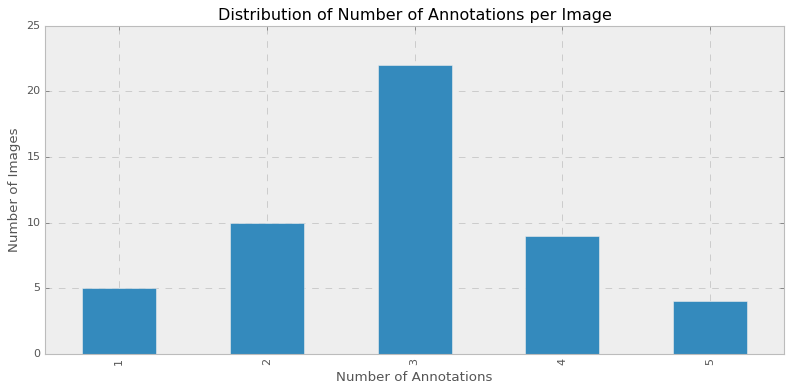

In [196]:
print("\n--- Basic Statistics ---")

num_unique_images = df_metadata['image_name'].nunique()
print(f"Number of unique images with annotations: {num_unique_images}")

print("\nAnnotations per annotator:")
print(df_metadata['annotator_name'].value_counts())

print("\nAnnotator professions (one per annotator):")
print(df_metadata.groupby('annotator_name')['annotator_profession'].first())

total_annotations = len(df_metadata)
print(f"\nTotal number of annotations: {total_annotations}")

print("\nAnnotations per image (distribution):")
annotations_per_image = df_metadata.groupby('image_name').size()
print(annotations_per_image.describe())

# Plot distribution of annotations per image
if not annotations_per_image.empty:
    plt.figure(figsize=(10, 5))
    annotations_per_image.value_counts().sort_index().plot(kind='bar')
    plt.title('Distribution of Number of Annotations per Image')
    plt.xlabel('Number of Annotations')
    plt.ylabel('Number of Images')
    plt.show()

### 3. Visualizing annotations


--- Testing utils.py and Visualizing ---

Processing image: person1631_virus_2826.jpeg
  Loaded original image from: data/annotations/original/person1631_virus_2826.jpeg
  Found 3 raw individual mask(s) for person1631_virus_2826.jpeg.
  Processing raw masks with 'utils.process_circled_annotation'...
  3 non-empty mask(s) for visualization after circle processing.
  Total 3 masks (incl. empty) sent for consensus.
  Consensus mask created with shape: (224, 224), Sum: 356


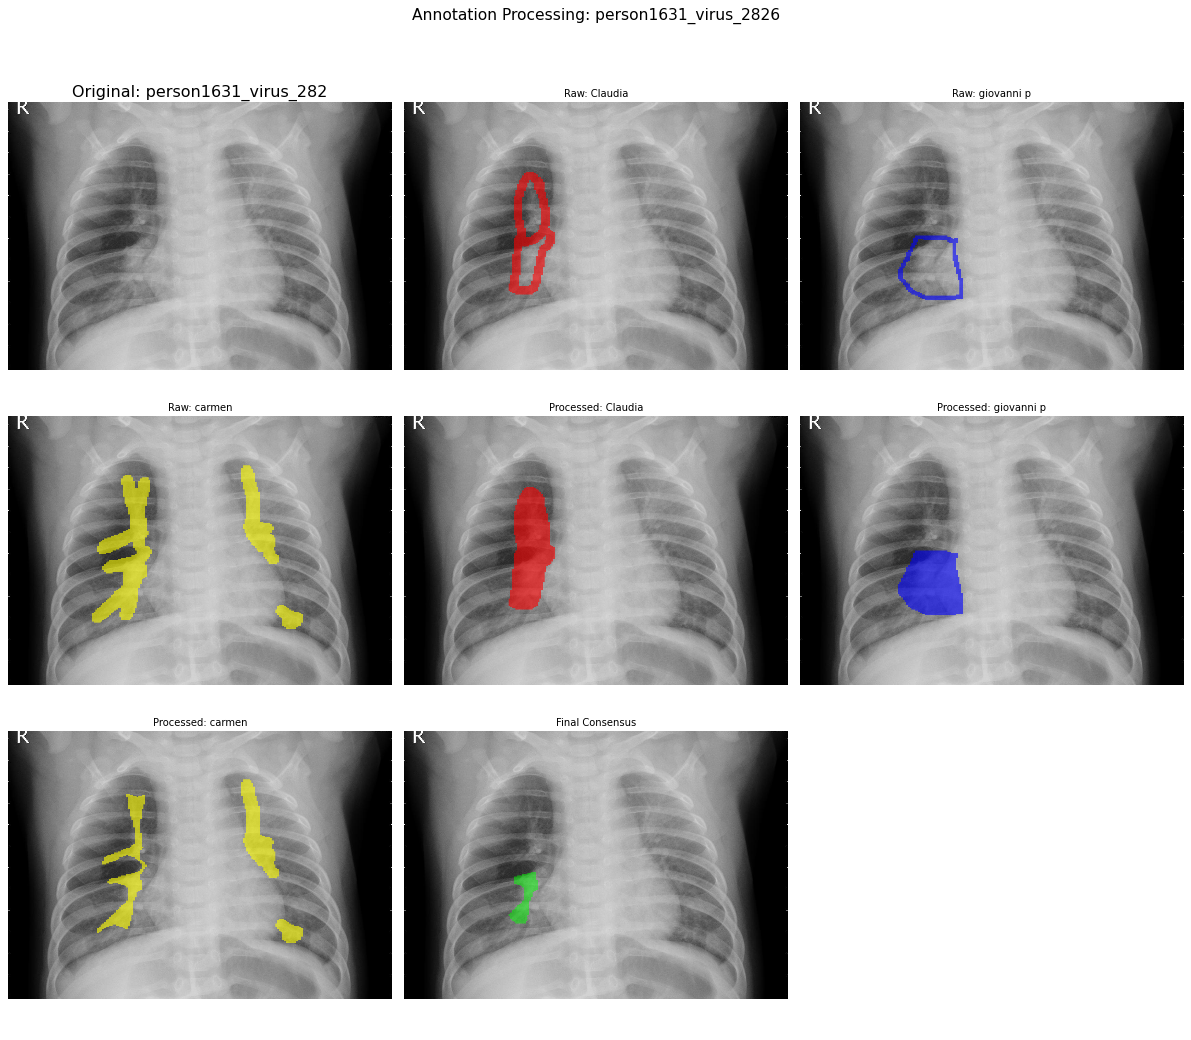


Processing image: person1647_virus_2848.jpeg
  Loaded original image from: data/annotations/original/person1647_virus_2848.jpeg
  Found 1 raw individual mask(s) for person1647_virus_2848.jpeg.
  Processing raw masks with 'utils.process_circled_annotation'...
  No non-empty masks remained after circle processing for person1647_virus_2848.jpeg (for visualization).
  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).


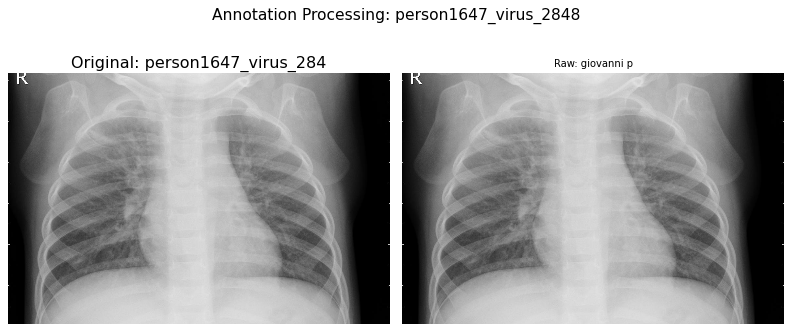

In [197]:
print("\n--- Testing utils.py and Visualizing ---")

sample_image_names = []
if not df_metadata.empty:
    image_counts = df_metadata['image_name'].value_counts()
    # Try to pick images with multiple annotations for diverse testing
    multi_annot_images = image_counts[image_counts > 1].index.tolist()
    single_annot_images = image_counts[image_counts == 1].index.tolist()
    
    if len(multi_annot_images) >= 1: # Prioritize multi-annotation images
        sample_image_names.extend(np.random.choice(multi_annot_images, size=min(1, len(multi_annot_images)), replace=False))
    if len(sample_image_names) < 2 and single_annot_images: # Fill with single annotation images if needed
            sample_image_names.extend(np.random.choice(single_annot_images, size=min(2-len(sample_image_names), len(single_annot_images)), replace=False))
    if not sample_image_names and not image_counts.empty: # Fallback
        sample_image_names.extend(np.random.choice(image_counts.index, size=min(2, len(image_counts.index)), replace=False))

if not sample_image_names:
    print("Could not select sample image names from metadata for visualization.")

for image_name in sample_image_names:
    print(f"\nProcessing image: {image_name}")
    original_image_path = os.path.join(ORIGINAL_IMAGES_DIR, image_name)
    try:
        original_pil_img = Image.open(original_image_path).convert("RGB")
        print(f"  Loaded original image from: {original_image_path}")
    except FileNotFoundError:
        print(f"  ERROR: Original image not found at {original_image_path}")
        continue
        
    # raw_masks_with_annotators will be a list of tuples: [(mask_array, annotator_name), ...]
    raw_masks_with_annotators = utils.get_masks_for_image_from_metadata(
        image_name,
        annotations_metadata,
        ANNOTATED_MASKS_DIR,
        target_size=TARGET_MASK_SIZE
    )
    
    if not raw_masks_with_annotators:
        print(f"  No raw masks found or loaded for {image_name}.")
        continue
    else:
        print(f"  Found {len(raw_masks_with_annotators)} raw individual mask(s) for {image_name}.")

    # Process raw circled annotations
    processed_masks_for_consensus_input = [] # This list will hold a mask for each annotator
    print(f"  Processing raw masks with 'utils.process_circled_annotation'...")
    for raw_mask, annotator_name in raw_masks_with_annotators: # raw_masks_with_annotators contains a mask for everyone
        processed_mask_output = utils.process_circled_annotation(
            raw_mask, # raw_mask itself could be an empty array if load_mask returned that
            initial_closing_kernel_size=INITIAL_PRE_CLOSING_KERNEL_SIZE,
            solidity_threshold=SOLIDITY_THRESHOLD,
            outline_fill_closing_kernel_size=OUTLINE_FILL_CLOSING_KERNEL_SIZE,
            outline_erosion_kernel_size=OUTLINE_EROSION_KERNEL_SIZE,
            filled_region_hole_closing_kernel_size=FILLED_REGION_HOLE_CLOSING_KERNEL_SIZE,
            min_contour_area=MIN_CONTOUR_AREA_FILTER
        )
        # Ensure process_circled_annotation always returns a mask (even if empty), not None
        if processed_mask_output is None:
                # This should ideally be handled inside process_circled_annotation to return empty array
                processed_mask_output = np.zeros(TARGET_MASK_SIZE, dtype=np.uint8)
        processed_masks_for_consensus_input.append(processed_mask_output) # Add all, even if empty

    # For visualization, we might still want to only show non-empty processed masks
    processed_masks_with_annotators_for_viz = []
    for i, (raw_mask_orig, annotator_name_orig) in enumerate(raw_masks_with_annotators):
        # Use the corresponding mask from processed_masks_for_consensus_input for visualization
        # This ensures we visualize what was actually sent for consensus
        corresponding_processed_mask = processed_masks_for_consensus_input[i]
        if corresponding_processed_mask.sum() > 0: # Only add to viz list if it has content
                processed_masks_with_annotators_for_viz.append((corresponding_processed_mask, annotator_name_orig))
    
    if not processed_masks_with_annotators_for_viz: # Check the list for visualization
        print(f"  No non-empty masks remained after circle processing for {image_name} (for visualization).")
    else:
        print(f"  {len(processed_masks_with_annotators_for_viz)} non-empty mask(s) for visualization after circle processing.")
        print(f"  Total {len(processed_masks_for_consensus_input)} masks (incl. empty) sent for consensus.")


    consensus_mask_np = None
    # Always attempt consensus if there were annotators, create_consensus_mask will handle empty list if needed
    # The list processed_masks_for_consensus_input will have one entry per annotator.
    if raw_masks_with_annotators: # Check if there were any raw masks to begin with
        consensus_mask_np = utils.create_consensus_mask(
            processed_masks_for_consensus_input, # Pass the list that includes potentially empty masks
            filter_type='open', 
            filter_kernel_size=3,
            consensus_method='intersection'
        )
        if consensus_mask_np is not None and consensus_mask_np.sum() > 0:
            print(f"  Consensus mask created with shape: {consensus_mask_np.shape}, Sum: {consensus_mask_np.sum()}")
        else:
            print("  Consensus mask is empty or failed to create (which is expected if an expert provided an empty mask for intersection).")
    else:
        print("  No raw masks available to create a consensus.")

    # Visualization
    num_raw_masks = len(raw_masks_with_annotators)
    num_processed_masks_viz = len(processed_masks_with_annotators_for_viz)

    total_plots = 1 + num_raw_masks + num_processed_masks_viz + (1 if consensus_mask_np is not None and consensus_mask_np.sum() > 0 else 0)
    
    if total_plots == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5,5))
            ax.imshow(original_pil_img)
            ax.set_title(f"Original: {image_name.split('.')[0][:20]}")
            ax.axis('off')
    else:
        cols = min(total_plots, 3) # Adjusted to 3 for potentially longer titles
        rows = (total_plots + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4.5)) # Slightly taller for titles
        if total_plots == 1: axes = [axes]
        else: axes = axes.flatten()
        
        plot_idx = 0

        if plot_idx < len(axes): # Original Image
            axes[plot_idx].imshow(original_pil_img)
            axes[plot_idx].set_title(f"Original: {image_name.split('.')[0][:20]}")
            axes[plot_idx].axis('off'); plot_idx += 1

        colors = [(255,0,0), (0,0,255), (255,255,0), (0,255,255), (255,0,255)] 

        # Raw Individual Mask Overlays with Annotator Name
        for i, (raw_mask, annotator_name) in enumerate(raw_masks_with_annotators):
            if plot_idx < len(axes) and raw_mask is not None:
                overlay_raw_pil = utils.overlay_binary_mask(original_pil_img.copy(), raw_mask, mask_color=colors[i % len(colors)], alpha=0.6)
                axes[plot_idx].imshow(overlay_raw_pil)
                title_text = f"Raw: {annotator_name[:15]}" # Truncate annotator name if too long
                if len(annotator_name) > 15: title_text += "..."
                axes[plot_idx].set_title(title_text, fontsize=9) # Smaller font for potentially long names
                axes[plot_idx].axis('off'); plot_idx += 1
        
        # Processed Individual Mask Overlays with Annotator Name
        for i, (processed_mask, annotator_name) in enumerate(processed_masks_with_annotators_for_viz):
            if plot_idx < len(axes) and processed_mask is not None:
                overlay_processed_pil = utils.overlay_binary_mask(original_pil_img.copy(), processed_mask, mask_color=colors[i % len(colors)], alpha=0.6)
                axes[plot_idx].imshow(overlay_processed_pil)
                title_text = f"Processed: {annotator_name[:10]}" # Truncate
                if len(annotator_name) > 10: title_text += "..."
                axes[plot_idx].set_title(title_text, fontsize=9)
                axes[plot_idx].axis('off'); plot_idx += 1

        # Overlay Consensus Mask
        if consensus_mask_np is not None and consensus_mask_np.sum() > 0 and plot_idx < len(axes):
            overlay_consensus_pil = utils.overlay_binary_mask(original_pil_img.copy(), consensus_mask_np, mask_color=(0, 255, 0), alpha=0.5)
            axes[plot_idx].imshow(overlay_consensus_pil)
            axes[plot_idx].set_title("Final Consensus", fontsize=9)
            axes[plot_idx].axis('off'); plot_idx += 1
        
        for i in range(plot_idx, len(axes)): axes[i].axis('off')

    plt.suptitle(f"Annotation Processing: {image_name.split('.')[0][:30]}", fontsize=14)
    plt.tight_layout(rect=[0, 0.02, 1, 0.96]) # Adjust rect to prevent suptitle overlap
    plt.show()
    

### 4. IoU Examples

In [205]:
if len(df_metadata['image_name'].unique()) > 0 and annotations_metadata:
    print("\n--- Example: Inter-Rater Agreement (IoU) for one image ---")
    # Pick an image that has multiple annotations
    annotations_per_image = df_metadata.groupby('image_name').size()
    multi_annotated_images = annotations_per_image[annotations_per_image > 1].index.tolist()
    
    if multi_annotated_images:
        example_image_name_iou = np.random.choice(multi_annotated_images)
        print(f"Calculating IoU for annotators of image: {example_image_name_iou}")
        
        masks_for_iou = utils.get_masks_for_image_from_metadata(
            example_image_name_iou,
            annotations_metadata,
            ANNOTATED_MASKS_DIR,
            target_size=TARGET_MASK_SIZE
        )
        
        # Apply morphological opening as per your README description before IoU
        processed_masks_for_iou = []
        for m in masks_for_iou:
            processed_m = utils.apply_morphological_filter(m, operation='open', kernel_size=3)
            if processed_m is not None:
                 processed_masks_for_iou.append(processed_m)


        if len(processed_masks_for_iou) >= 2:
            # Calculate IoU for all pairs of annotators
            annotator_records = [rec for rec in annotations_metadata if rec['image_name'] == example_image_name_iou]

            for i in range(len(processed_masks_for_iou)):
                for j in range(i + 1, len(processed_masks_for_iou)):
                    mask1, annotator1_name = processed_masks_for_iou[i]
                    mask2, annotator2_name = processed_masks_for_iou[j]
                    iou_score = utils.calculate_iou(mask1, mask2)
                    

                    print(f"  IoU between mask {i+1} and mask {j+1}: {iou_score:.4f}")
        else:
            print(f"  Not enough masks ({len(processed_masks_for_iou)}) for {example_image_name_iou} to calculate pairwise IoU.")
    else:
        print("  No images found with multiple annotations to demonstrate IoU calculation.")


--- Example: Inter-Rater Agreement (IoU) for one image ---
Calculating IoU for annotators of image: person78_bacteria_385.jpeg
  IoU between mask 1 and mask 2: 0.0718
  IoU between mask 1 and mask 3: 0.0000
  IoU between mask 2 and mask 3: 0.0000
